# ACE 592 - "All the President's Moods" Assignment

## Vitor Machado de Oliveira Fernandes
    

In [2]:
import pandas as pd
import json 
import matplotlib.pyplot as plt
import matplotlib
import re
import string
from nltk.corpus import stopwords
import regex
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

\
\
**1- Load a json file of all the president's tweets from August 30 to November 5th**.

Put the following information into a dataframe: The full text of the Tweet; Any users mentioned in the Tweet. (string); The timestamp. (datetime); The date (YYYY-MM-DD) of the Tweet. (date); Retweets (numeric); Favorites (numeric); Whether the Tweet was censored, meaning zero retweets (binary/boolean).

In [127]:
trump_twt = pd.read_json(r"/Users/VMOF/Desktop/Ace592 hw1 data/Trump_tweets.json")
#trump_twt.info()
#trump_twt.head(3)

trump_twt = trump_twt.drop_duplicates(subset=['created_at', 'full_text'], keep = 'first') #droping duplicate tweets

In [128]:
trump_twt = trump_twt.loc[:,("created_at","full_text","favorite_count","retweet_count","entities")]
trump_twt["censored"] = trump_twt["retweet_count"] == 0
trump_twt.rename({"created_at": "timestamp"}, axis = 1, inplace = True)
trump_twt["date"] = trump_twt["timestamp"].dt.date
trump_twt["timestamp"] = pd.to_datetime(trump_twt["timestamp"])

\
\
**2- Create a "clean_text" column by doing the following to "full_text":**

removing links(http), hashtags, mentions, converting text to lower case, removing punctuation.

In [129]:
#re is already imported
#Split words
text = [x.split(' ') for x in trump_twt.full_text]

#loop and remove links, mentions and #
prefixes = ('https', '#', '@','\n','\r')
remv_punc = str.maketrans('','',string.punctuation + '“' +"‘"+'”' + "'")
separator = ' '
replaces = ['‘',"\n","\r","’",'"']
for n in range(len(text)):
  text[n] = [x for x in text[n] if not x.startswith(prefixes)]
  text[n] = separator.join(text[n]).lower()
  for i in replaces:
    text[n] = text[n].replace(i," ")
  text[n] = text[n].translate(remv_punc)
  text[n] = text[n].split(' ')
  text[n] = separator.join(text[n]).lower()

trump_twt['clean_text'] = text
#Drop duplicates
df = pd.DataFrame(trump_twt.drop_duplicates('clean_text'))

df.head(3)

,timestamp,full_text,favorite_count,retweet_count,entities,censored,date,clean_text
0,2020-11-05 15:37:40+00:00,Fmr NV AG Laxalt: ‘No Question‘ Trump Would Ha...,124472,27745,"{'hashtags': [], 'symbols': [], 'user_mentions...",False,2020-11-05,fmr nv ag laxalt no question trump would hav...
1,2020-11-05 15:09:19+00:00,ANY VOTE THAT CAME IN AFTER ELECTION DAY WILL ...,0,0,"{'hashtags': [], 'symbols': [], 'user_mentions...",True,2020-11-05,any vote that came in after election day will ...
2,2020-11-05 14:12:37+00:00,STOP THE COUNT!,750449,120833,"{'hashtags': [], 'symbols': [], 'user_mentions...",False,2020-11-05,stop the count


**Now report:**\
The top 10 most common words (omitting stop words).
The top 5 Twitter accounts that are mentioned.
The top 5 most liked ("favorited") tweets.
The top 5 hashtags (hint: use a regular expression).

**Top 10 most common words (- stop words):**

In [130]:
#top 10 most common words
#Split text in words
words = [x.split(" ") for x in df['clean_text']]
words_list = [pd.Series(x).value_counts() for x in words]
word_df = pd.concat(words_list,axis=1).fillna(0).T

# removing stopwords:
#Get stopwords to delete
sw_list = stopwords.words('english') + [" ", '']

words_nsw = word_df.loc[:,~word_df.T.index.isin(sw_list)]


In [131]:
'''Top 10 words'''
top10 = words_nsw.sum().sort_values(ascending=False)
print(top10[0:10])

biden      319.0
great      249.0
vote       229.0
joe        215.0
amp        215.0
thank      148.0
people     133.0
get        120.0
big        108.0
america    103.0
dtype: float64


**Sorting tweets by most favorited:**

In [132]:
most_liked = trump_twt.sort_values(by = "favorite_count", ascending = False)
print(most_liked.full_text[0:5])

1014    Tonight, @FLOTUS and I tested positive for COV...
1012       Going welI, I think! Thank you to all. LOVE!!!
17      WE ARE LOOKING REALLY GOOD ALL OVER THE COUNTR...
16       I will be making a statement tonight. A big WIN!
24      This Tweet from @realDonaldTrump has been with...
Name: full_text, dtype: object


**Top five hashtags:**

In [133]:
#Came to the conclusion that using "full_text" instead of entities is easier.

counts = trump_twt["full_text"].str.findall(r'(#\w+)').explode().value_counts()
counts.head(5)

#MAGA                     116
#VOTE                       8
#MakeAmericaGreatAgain      7
#2A                         7
#TrumpPence2020             4
Name: full_text, dtype: int64

**Top 5 twitter accounts mentioned:**

In [134]:
counts2 = trump_twt["full_text"].str.findall(r'(@\w+)').explode().value_counts()
counts2.head(5)

@BreitbartNews    49
@FoxNews          31
@OANN             10
@cspan             8
@CNN               8
Name: full_text, dtype: int64

\
\
**3- Graph the daily volume of tweets over time, while annotating any major events.**

In [12]:
plot_data = trump_twt.groupby(["date"]).count()

Text(0, 0.5, '# of tweets')

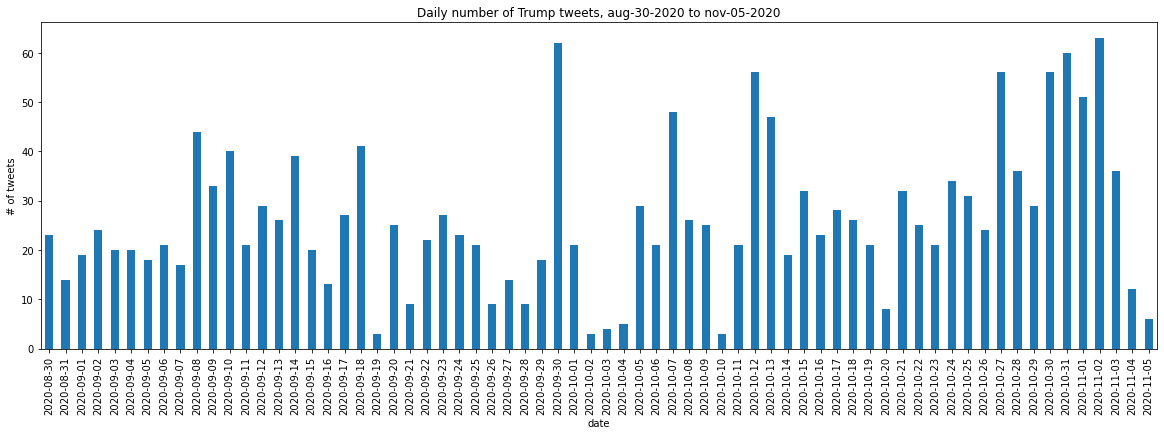

In [135]:
plot_data["full_text"].plot(kind='bar',figsize=(20,6),legend=None) #now find a way of annotating major events - maybe use plt.xticks((old),(new))
plt.title("Daily number of Trump tweets, aug-30-2020 to nov-05-2020")
plt.ylabel("# of tweets")

# label_list = [
#     (pd.to_datetime("2020-11-3"), 'Election day', 'y'),
#     (pd.to_datetime("2020-10-1"), "Trump gets COVID", 'b'),
#     (pd.to_datetime("2020-9-27"), "1st Debate", 'g'),
#     (pd.to_datetime("2020-10-7"), "2nd Debate", 'g'),
#     (pd.to_datetime("2020-10-22"), "3rd Debate", 'g')
# ]

# ax = plt.gca()

# for date_point, label, clr in label_list:
#     plt.axvline(x=date_point, color=clr)
#     plt.text(date_point, ax.get_ylim()[1]-4, label,
#              horizontalalignment='center',
#              verticalalignment='center',
#              color=clr,
#              bbox=dict(facecolor='white', alpha=0.9)) ##DIDNT WORK


\
\
**4 - Run the tweets through sentiment analysis, and report:** \
The 20 most "negative" and "positive" words.
A graph of the sentiment over time.

In [14]:
sid = SentimentIntensityAnalyzer()

In [211]:
sentiment = words_nsw.sum().sort_values(ascending=False).reset_index()
sentiment["score"] = [sid.polarity_scores(x)['compound'] for x in s['index']]

#top 20 positive words:
sentiment = sentiment.sort_values("score", ascending = False)
print(sentiment[1:20])

#Top 20 negative words:
sentiment = sentiment = sentiment.sort_values("score", ascending = True)
print(sentiment[1:20])

                index      0   score
1743         glorious    2.0  0.6369
448           freedom    8.0  0.6369
216              love   17.0  0.6369
149              best   23.0  0.6369
250          greatest   14.0  0.6369
1704          awesome    2.0  0.6249
1               great  249.0  0.6249
1323      outstanding    3.0  0.6124
501         beautiful    8.0  0.5994
3919            loved    1.0  0.5994
1781          blessed    2.0  0.5994
795          champion    5.0  0.5994
178   congratulations   20.0  0.5994
3933      magnificent    1.0  0.5994
562             super    7.0  0.5994
2052              joy    2.0  0.5859
902            winner    4.0  0.5859
532            beauty    7.0  0.5859
28                win   72.0  0.5859
            index     0   score
1718       murder   2.0 -0.6908
607     terrorist   6.0 -0.6908
2015    terrorism   2.0 -0.6808
634          hell   6.0 -0.6808
1010       killed   4.0 -0.6705
4076     murdered   1.0 -0.6597
2126         evil   1.0 -0.6597
1471

In [212]:
trump_twt["sentiment"] = [sid.polarity_scores(x)['compound'] for x in trump_twt["clean_text"]]
sent_plot = trump_twt[["date","clean_text","sentiment"]]

Text(0.5, 1.0, "D. Trump Tweets' Sentiment Score Over Time")

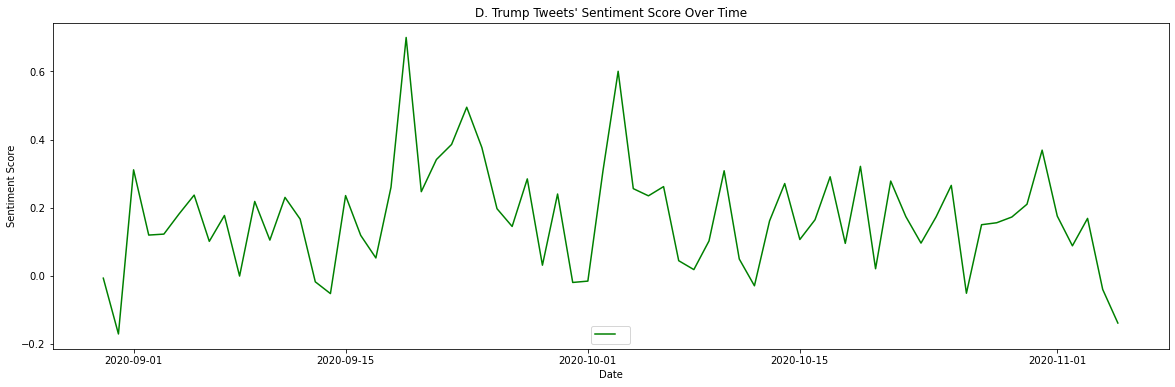

In [213]:
sent_plot.groupby("date").sentiment.mean().plot(figsize=(20,6),legend = None, label = " ", color = "green")
plt.legend(loc="lower center")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.title("D. Trump Tweets' Sentiment Score Over Time")


**5 - Trump and the Stock Market**

Read in the time series dataset of S&P 500 closing, daily prices. Then merge this data to Trump's daily sentiment scores. Graph both of them (EXTRA CREDIT GRAPH), calculate their correlation, and interpret what you see.

Since Trump often comments on the stock market but the stock market may also react to his tweets, it is not clear how the causal relationship should work. Describe in detail how you would answer the question: "Did President Trump's tweet sentiment influence the stock market?" Specifically describe:

The data you would need in addition to these data sources.
The way you would read in the data and manipulate it.
The sort of analysis or statistics you would calculate to answer the question.

In [186]:
stock_prices = pd.read_csv(r"/Users/VMOF/Desktop/Ace592 hw1 data/SandP500.csv", delimiter = ',')

stock_prices = stock_prices.rename(columns={"DATE":"date", "SP500":"sp500"})
stock_prices["date"] = pd.to_datetime(stock_prices["date"]) #convert Dtype
#stock_prices.info()
stock_prices = stock_prices[(stock_prices['date'] > '2020-08-30') & (stock_prices['date'] < '2020-11-05')] #selecting days we need
stock_prices = stock_prices.drop(stock_prices[stock_prices.sp500 == '.'].index)
stock_prices["sp500"] = pd.to_numeric(stock_prices["sp500"])
stock_prices = stock_prices.set_index(stock_prices['date'])

In [247]:
sent_plot["check"] = sent_plot["clean_text"] == ""
sent_plot.sort_values("clean_text")

sent_plot2 = sent_plot.loc[sent_plot.clean_text != True]
sent_plot2 = sent_plot2.set_index("date")
sent_plot2 =  sent_plot2.groupby("date").mean()

#merging
sp_sent = stock_prices.merge(sent_plot2, left_index = True, right_index = True, how = "left")
sp_sent = sp_sent.drop("check", 1)
sp_sent = sp_sent.drop("date", 1)

<ipython-input-247-5a8b257a6245>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_plot["check"] = sent_plot["clean_text"] == ""


In [265]:
#Returns and correlation, grouped by day
sp_sent["returns"] = sp_sent["sp500"].pct_change(axis=0)
returns = sp_sent.drop(columns="sp500").dropna()

#Pearson correlation
from scipy.stats import pearsonr
corr, _ = pearsonr(returns["sentiment"], returns["returns"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.230


**There seems to be a negative correlation between the average daily sentiment of president Trump's tweets and returns of the S&P500 index; albeit not too large in magnitude. I suspect this correlation will change significantly if the data is aggregated by hours or minutes instead (which also don't necessarily mean anything).**

Text(0.5, 1.0, "S&P daily return vs Trump's Twitter Sentiment Score over time")

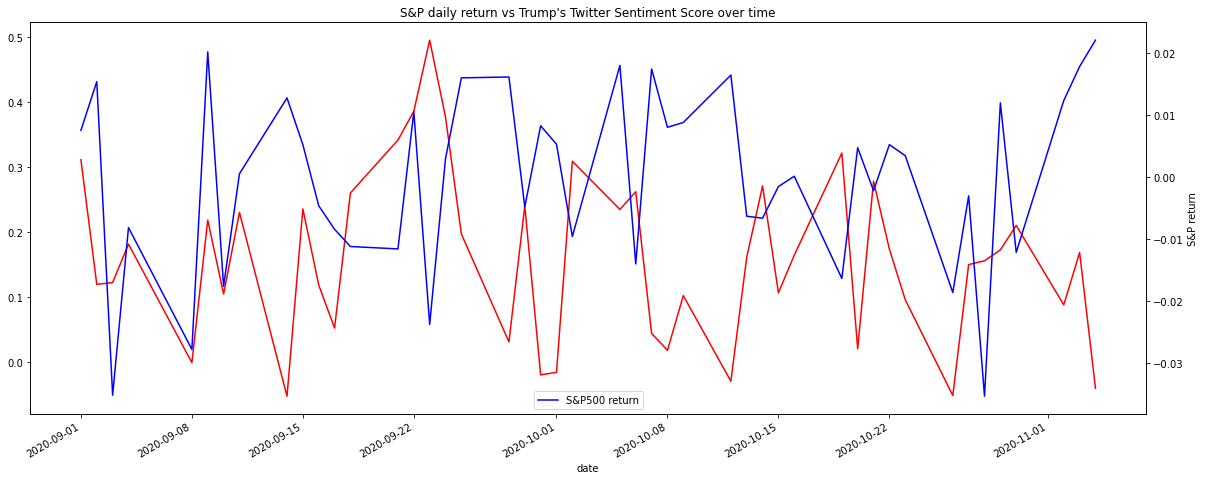

In [258]:
#plotting returns vs sentiment score
plt.figure(figsize=(20,8))
plt.xlabel('Daily twitter sentiment vs. S&P 500 returns')
ax1 = returns.sentiment.plot(color='red', label="sentiment score")
ax2 = returns.returns.plot(color='blue', label='S&P500 return', secondary_y=True)
plt.legend(loc="lower center")
plt.xlabel("Date")
plt.ylabel("S&P return")
plt.title("S&P daily return vs Trump's Twitter Sentiment Score over time")